In [1]:
# ==============================================================
# 1. Install & Import Libraries
# ==============================================================

# Install required packages
!pip install kagglehub tensorflow seaborn matplotlib scikit-learn

# Import necessary libraries
import os
import zipfile
import shutil
import random
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==============================================================
# 2. Download PlantVillage Dataset
# ==============================================================

# Set custom download location
os.environ["KAGGLEHUB_CACHE"] = "/Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01"

# Local setup
BASE_DIR = "/Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01"
os.makedirs(BASE_DIR, exist_ok=True)

# For Colab: Uncomment to mount Drive
# from google.colab import drive
# drive.mount('/content/drive')
# BASE_DIR = "/content/drive/MyDrive/Plant_leaf_dieases_01"

# Download PlantVillage Dataset
plantvillage_path = kagglehub.dataset_download("mohitsingh1804/plantvillage")
print("PlantVillage Dataset downloaded to:", plantvillage_path)

# Extract Dataset
extract_dir = os.path.join(BASE_DIR, "datasets/mohitsingh1804/plantvillage")
os.makedirs(extract_dir, exist_ok=True)
zip_path = os.path.join(plantvillage_path, "plantvillage.zip")
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset extracted to:", extract_dir)
else:
    print("Dataset already extracted at:", plantvillage_path)

# Find class root dynamically
source_dir = extract_dir
for root, dirs, _ in os.walk(extract_dir):
    if len(dirs) >= 38 and any('___' in d or '_' in d for d in dirs):
        source_dir = root
        break
print("PlantVillage class root:", source_dir)

# List classes
classes = sorted([d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))])
print(f"PlantVillage classes ({len(classes)}):", classes)

PlantVillage Dataset downloaded to: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/datasets/mohitsingh1804/plantvillage/versions/1
Dataset already extracted at: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/datasets/mohitsingh1804/plantvillage/versions/1
PlantVillage class root: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/datasets/mohitsingh1804/plantvillage/versions/1/PlantVillage/train
PlantVillage classes (38): ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot

In [ ]:
# ==============================================================
# 3. Auto Split into Train / Val / Test
# ==============================================================

# Set up directories
train_dir = os.path.join(BASE_DIR, "data/train")
val_dir   = os.path.join(BASE_DIR, "data/val")
test_dir  = os.path.join(BASE_DIR, "data/test")

# Clear existing directories if they exist
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Define split ratios
train_split = 0.7
val_split   = 0.2
test_split  = 0.1

# Split data
random.seed(42)  # For reproducibility
for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    
    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    random.shuffle(images)
    total = len(images)
    
    train_count = int(total * train_split)
    val_count   = int(total * val_split)
    
    splits = {
        train_dir: images[:train_count],
        val_dir:   images[train_count:train_count+val_count],
        test_dir:  images[train_count+val_count:]
    }
    
    # Copy files to respective directories
    for split_dir, split_files in splits.items():
        split_cls_path = os.path.join(split_dir, cls)
        os.makedirs(split_cls_path, exist_ok=True)
        for f in split_files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(split_cls_path, f))

print("Data split into train/val/test from PlantVillage dataset.")

Data split into train/val/test from PlantVillage dataset.


In [ ]:
# ==============================================================
# 4. Data Generators
# ==============================================================

# Image parameters
IMG_SIZE = (224, 224)
# Data augmentation
BATCH_SIZE = 32

# Create ImageDataGenerators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

# Create generators
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Create validation generator without augmentation
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Create test generator without augmentation
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Number of classes
num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)

# Save class indices to JSON file
import json
os.makedirs("models", exist_ok=True)
with open("models/class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)
print("Class indices saved to: models/class_indices.json")

Found 30393 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.
Found 4378 images belonging to 38 classes.
Classes: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Le

In [ ]:

# ==============================================================
# 5. Class Weights
# ==============================================================

# Compute class weights to handle class imbalance
y_train = train_gen.classes
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 2.2722039473684212, 1: 2.3049446382526924, 2: 5.193609022556391, 3: 0.868421052631579, 4: 0.9510294761874961, 5: 1.3579215440979358, 6: 1.6732547896939, 7: 2.786814597469283, 8: 1.1991241221494515, 9: 1.4515713057598625, 10: 1.2304858299595143, 11: 1.2118421052631578, 12: 1.0333537331701346, 13: 1.3285976569330302, 14: 3.3747501665556294, 15: 0.2594277617494921, 16: 0.621940738315462, 17: 3.9791830322073842, 18: 1.4359349900784277, 19: 0.9659610983981693, 20: 1.4282424812030075, 21: 1.4282424812030075, 22: 9.521616541353383, 23: 3.8638443935926774, 24: 0.2806371191135734, 25: 0.778788499974376, 26: 1.290025466893039, 27: 3.1488810609200164, 28: 0.6715497812541429, 29: 1.4282424812030075, 30: 0.7488911886457718, 31: 1.503413138108429, 32: 0.807079505018854, 33: 0.8526820783301537, 34: 1.017577340297308, 35: 0.26660526315789473, 36: 3.826869806094183, 37: 0.8976608187134503}


In [ ]:
# ==============================================================
# 6. Model 1: CNN with L2 + BatchNorm
# ==============================================================

# Build CNN model with L2 regularization and Batch Normalization
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

# Compile the model
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("✅ CNN model created and compiled successfully!")

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-29 02:00:29.296144: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-29 02:00:29.296440: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-29 02:00:29.296462: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-29 02:00:29.296766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-29 02:00:29.296783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

✅ CNN model created and compiled successfully!


In [ ]:
# ==============================================================
# 7. Model 2: MobileNetV2
# ==============================================================

# Build MobileNetV2 model
base_mobilenet = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                             include_top=False, weights="imagenet")
base_mobilenet.trainable = False

x = layers.GlobalAveragePooling2D()(base_mobilenet.output)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

# Create and compile the model
mobilenet_model = models.Model(base_mobilenet.input, output)
mobilenet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("✅ MobileNetV2 model created and compiled successfully!")

✅ MobileNetV2 model created and compiled successfully!


In [ ]:
# ==============================================================
# 8. Model 3: ResNet50
# ==============================================================

# Build ResNet50 model
base_resnet = ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                       include_top=False, weights="imagenet")
base_resnet.trainable = False

z = layers.GlobalAveragePooling2D()(base_resnet.output)
z = layers.Dense(512, activation="relu")(z)
z = layers.Dropout(0.5)(z)
output_resnet = layers.Dense(num_classes, activation="softmax")(z)

resnet_model = models.Model(base_resnet.input, output_resnet)
resnet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("✅ ResNet50 model created and compiled successfully!")

✅ ResNet50 model created and compiled successfully!


In [9]:
# ==============================================================
# 9. Training
# ==============================================================

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Train models
EPOCHS = 20

# Train CNN model
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen,
                            epochs=EPOCHS, callbacks=callbacks,
                            class_weight=class_weights)

# Train MobileNetV2 model
history_mobilenet = mobilenet_model.fit(train_gen, validation_data=val_gen,
                                        epochs=EPOCHS, callbacks=callbacks,
                                        class_weight=class_weights)

# Train ResNet50 model
history_resnet = resnet_model.fit(train_gen, validation_data=val_gen,
                                  epochs=EPOCHS, callbacks=callbacks,
                                  class_weight=class_weights)

# Fine-tune ResNet50
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss="categorical_crossentropy", metrics=["accuracy"])

history_finetune = resnet_model.fit(train_gen, validation_data=val_gen,
                                    epochs=20, callbacks=callbacks,
                                    class_weight=class_weights)


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-09-29 02:00:34.237208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


950/950 ━━━━━━━━━━━━━━━━━━━━ 663s 694ms/step - accuracy: 0.2256 - loss: 176.3338 - val_accuracy: 0.3650 - val_loss: 119.1245 - learning_rate: 0.0010
Epoch 2/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 737s 776ms/step - accuracy: 0.3687 - loss: 129.4489 - val_accuracy: 0.4162 - val_loss: 94.8382 - learning_rate: 0.0010
Epoch 3/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 740s 778ms/step - accuracy: 0.4167 - loss: 80.3883 - val_accuracy: 0.4767 - val_loss: 51.2562 - learning_rate: 0.0010
Epoch 4/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 518s 545ms/step - accuracy: 0.4439 - loss: 60.0644 - val_accuracy: 0.4801 - val_loss: 45.0279 - learning_rate: 0.0010
Epoch 5/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 654s 689ms/step - accuracy: 0.4790 - loss: 43.4151 - val_accuracy: 0.5144 - val_loss: 36.5096 - learning_rate: 0.0010
Epoch 6/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 576s 606ms/step - accuracy: 0.5015 - loss: 34.8694 - val_accuracy: 0.4327 - val_loss: 49.3327 - learning_rate: 0.0010
Epoch 7/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 607s 639ms/step - ac

2025-09-29 10:15:11.432 python[32892:1640348] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-32892-2025-09-29_10_15_11‚ÄØAM-587781514‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.


950/950 ━━━━━━━━━━━━━━━━━━━━ 695s 731ms/step - accuracy: 0.0291 - loss: 3.8675 - val_accuracy: 0.0289 - val_loss: 3.6055 - learning_rate: 0.0010
Epoch 4/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 681s 716ms/step - accuracy: 0.0326 - loss: 3.7399 - val_accuracy: 0.0329 - val_loss: 3.4251 - learning_rate: 5.0000e-04
Epoch 5/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 748s 786ms/step - accuracy: 0.0337 - loss: 3.7112 - val_accuracy: 0.0495 - val_loss: 3.4111 - learning_rate: 5.0000e-04
Epoch 1/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 900s 937ms/step - accuracy: 0.0515 - loss: 4.1482 - val_accuracy: 0.1674 - val_loss: 2.9961 - learning_rate: 1.0000e-05
Epoch 2/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 914s 962ms/step - accuracy: 0.1105 - loss: 3.5849 - val_accuracy: 0.2545 - val_loss: 2.6292 - learning_rate: 1.0000e-05
Epoch 3/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 915s 963ms/step - accuracy: 0.1661 - loss: 3.2781 - val_accuracy: 0.2963 - val_loss: 2.4463 - learning_rate: 1.0000e-05
Epoch 4/20
950/950 ━━━━━━━━━━━━━━━━━━━━ 892s 939ms/step


=== CNN + L2 + BN (PlantVillage) Evaluation ===
Accuracy: 0.8136
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.79      0.79      0.79        52
                                 Apple___Black_rot       0.54      0.98      0.70        50
                          Apple___Cedar_apple_rust       0.60      0.95      0.74        22
                                   Apple___healthy       0.85      0.80      0.82       132
                               Blueberry___healthy       0.95      0.74      0.83       121
          Cherry_(including_sour)___Powdery_mildew       0.92      0.89      0.90        85
                 Cherry_(including_sour)___healthy       0.54      0.96      0.69        70
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.56      0.71        41
                       Corn_(maize)___Common_rust_       0.91      1.00      0.95        96
             

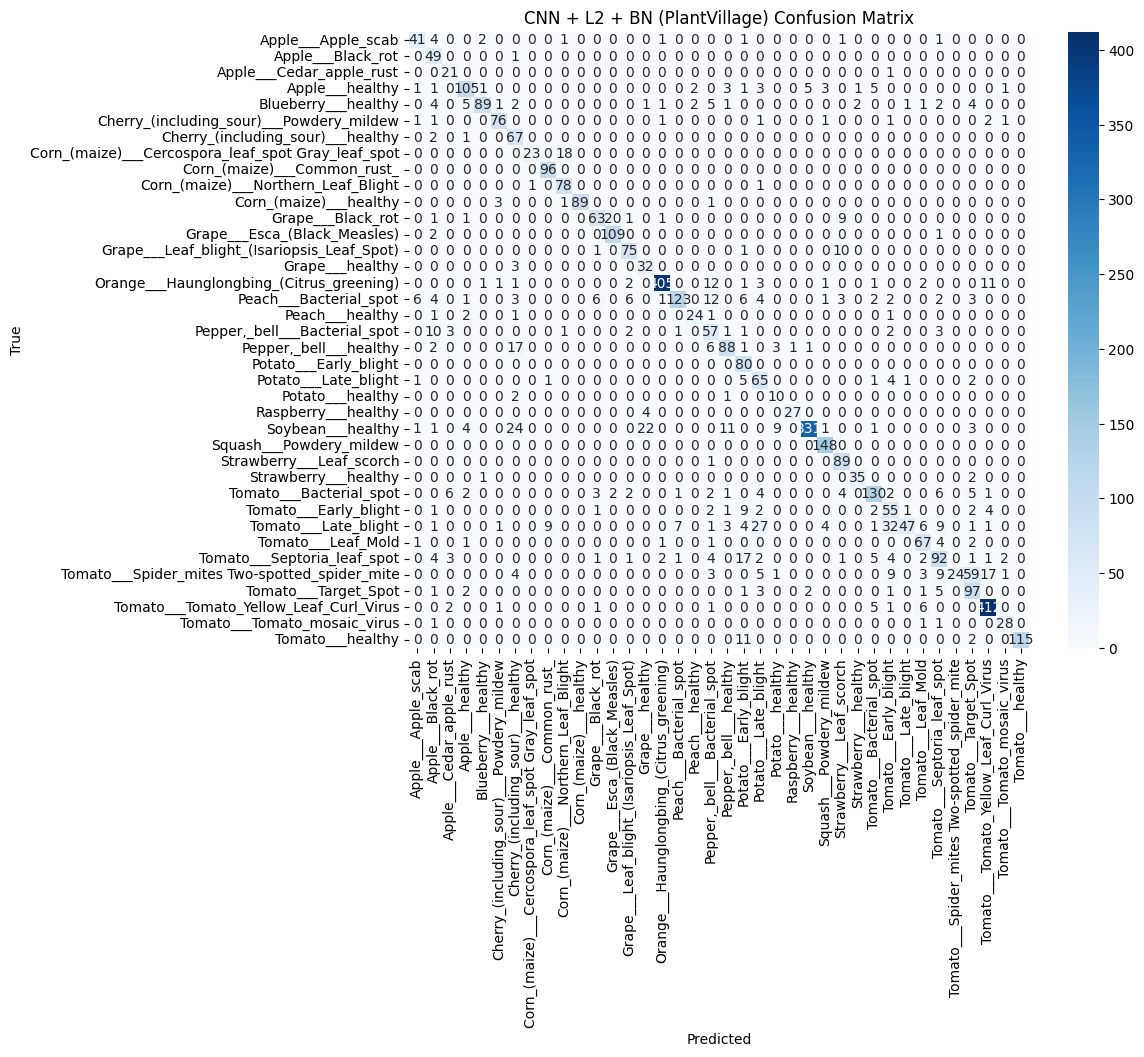

Confusion matrix saved to: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/models/CNN_+_L2_+_BN_(PlantVillage)_confusion_matrix.png

=== MobileNetV2 (PlantVillage) Evaluation ===
Accuracy: 0.9338
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.89      0.96      0.93        52
                                 Apple___Black_rot       0.96      1.00      0.98        50
                          Apple___Cedar_apple_rust       1.00      0.95      0.98        22
                                   Apple___healthy       0.98      0.98      0.98       132
                               Blueberry___healthy       0.97      1.00      0.98       121
          Cherry_(including_sour)___Powdery_mildew       0.98      0.94      0.96        85
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99        70
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  

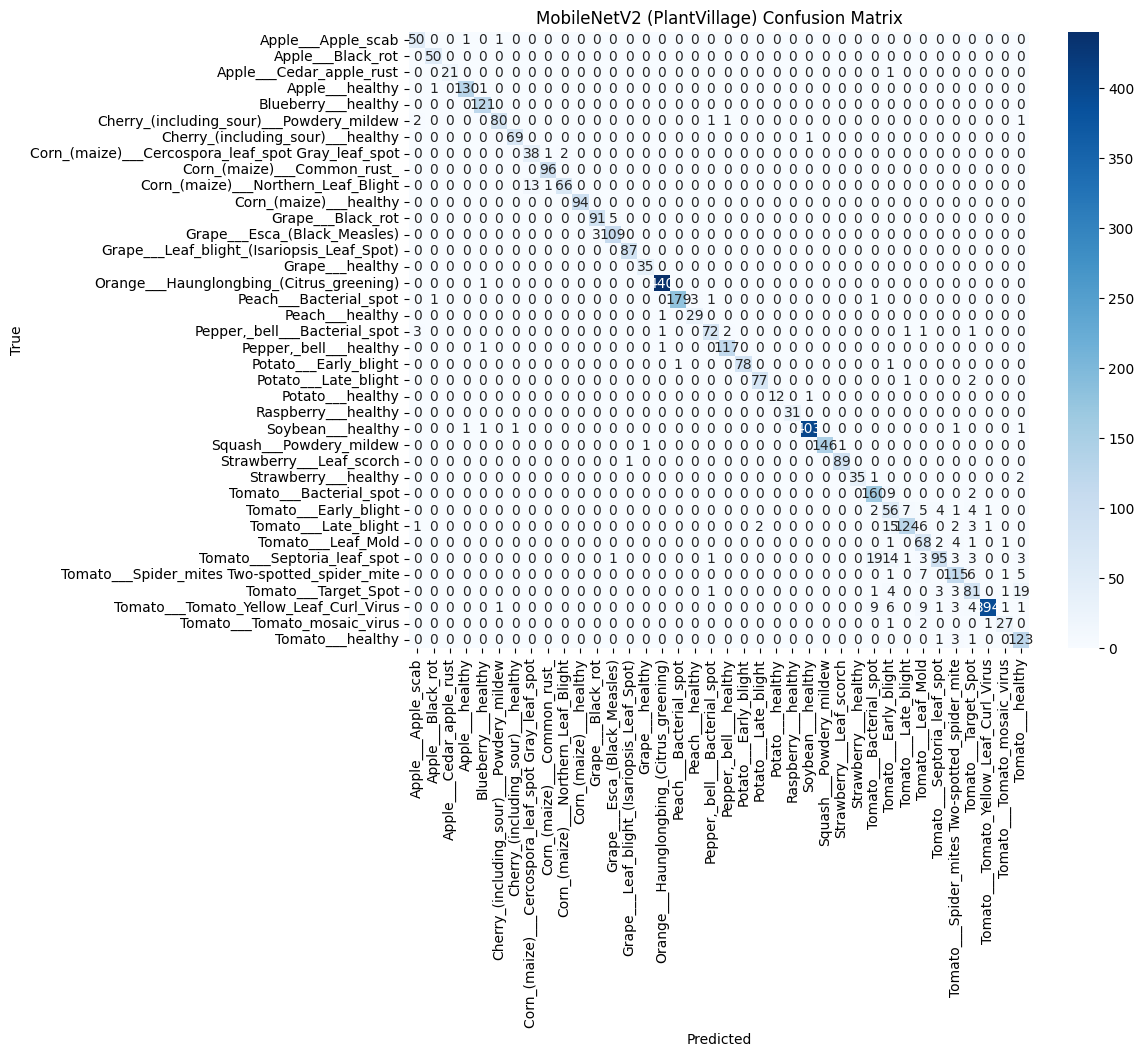

Confusion matrix saved to: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/models/MobileNetV2_(PlantVillage)_confusion_matrix.png

=== ResNet50 (Fine-tuned, PlantVillage) Evaluation ===
Accuracy: 0.2124


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        52
                                 Apple___Black_rot       0.00      0.00      0.00        50
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        22
                                   Apple___healthy       0.00      0.00      0.00       132
                               Blueberry___healthy       0.35      0.05      0.09       121
          Cherry_(including_sour)___Powdery_mildew       0.25      0.59      0.35        85
                 Cherry_(including_sour)___healthy       0.23      0.36      0.28        70
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.28      0.73      0.40        41
                       Corn_(maize)___Common_rust_       0.38      0.92      0.54        96
               Corn_(maize)___Northern_Leaf_Blight       0.53      0.11      0.

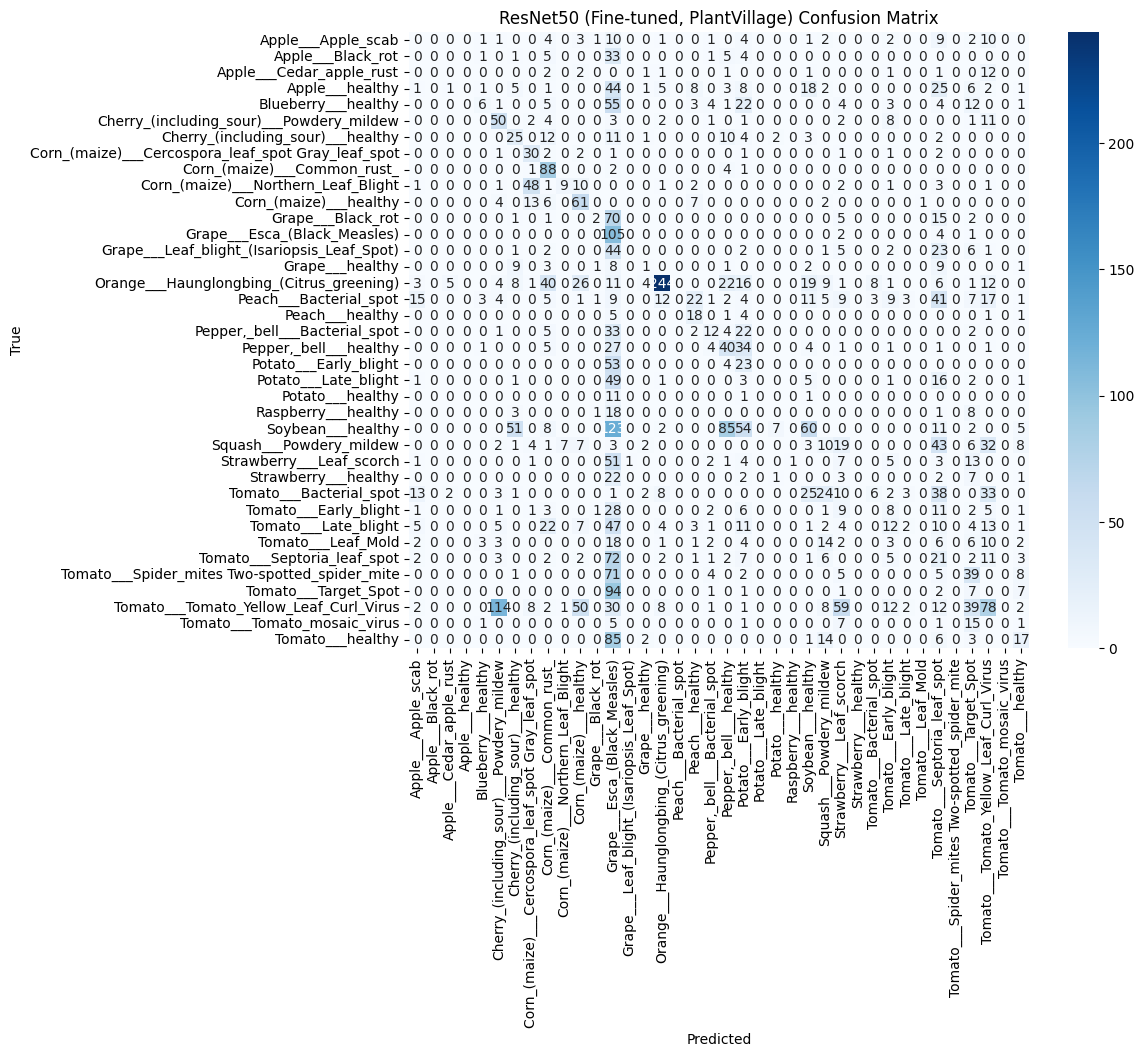

Confusion matrix saved to: /Users/yasiruchamuditha/Documents/GitHub/Plant_leaf_dieases_01/models/ResNet50_(Fine-tuned,_PlantVillage)_confusion_matrix.png


In [10]:
# ==============================================================
# 10. Evaluation
# ==============================================================

def evaluate_model(model, data_gen, label="Model"):
    """
    Evaluates a model on the test set, computing accuracy, precision, recall, F1-score,
    and generating a confusion matrix. Saves metrics and plots to files.
    
    Args:
        model: Trained Keras model (e.g., cnn_model, mobilenet_model, resnet_model).
        data_gen: Test data generator (test_gen) with images and labels.
        label: Model name for display (e.g., 'CNN + L2 + BN (PlantVillage)').
    """
    print(f"\n=== {label} Evaluation ===")
    # Compute accuracy
    val_loss, val_acc = model.evaluate(data_gen, verbose=0)
    print(f"Accuracy: {val_acc:.4f}")

    # Generate predictions and compute precision, recall, F1-score
    y_true = data_gen.classes
    y_pred = np.argmax(model.predict(data_gen, verbose=0), axis=1)

    # Classification report (precision, recall, F1-score per class and averages)
    report = classification_report(y_true, y_pred, target_names=list(data_gen.class_indices.keys()))
    print(report)

    # Save metrics to file
    metrics_file = os.path.join(BASE_DIR, f"models/{label.replace(' ', '_')}_metrics.txt")
    with open(metrics_file, "w") as f:
        f.write(f"{label} Evaluation\n")
        f.write(f"Accuracy: {val_acc:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
    print(f"Metrics saved to: {metrics_file}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=data_gen.class_indices.keys(),
                yticklabels=data_gen.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{label} Confusion Matrix")
    
    # Save confusion matrix plot
    cm_file = os.path.join(BASE_DIR, f"models/{label.replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_file)
    plt.show()
    print(f"Confusion matrix saved to: {cm_file}")

# Evaluate all three models
evaluate_model(cnn_model, test_gen, "CNN + L2 + BN (PlantVillage)")
evaluate_model(mobilenet_model, test_gen, "MobileNetV2 (PlantVillage)")
evaluate_model(resnet_model, test_gen, "ResNet50 (Fine-tuned, PlantVillage)")

In [11]:
# ==============================================================
# 11. Save models
# ==============================================================

# Save CNN model
cnn_model.save("models/cnn_model.h5")

# Save MobileNetV2 model
mobilenet_model.save("models/mobilenet_model.h5")

# Save ResNet50 model (fine-tuned)
resnet_model.save("models/resnet_model.h5")

print("✅ All models saved inside /models folder")

✅ All models saved inside /models folder
